In [88]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import fsolve
import os
from glob import glob
from re import match, search
from statistics import variance
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import LiuInt as LI #Package with functions for integrating over the BPDF, parameterized by xi_avg and xi_variance
import ipywidgets as wgt

path = r"./data"

##############################

def computeProgressVariable(data, header, components = ['H2', 'H2O', 'CO', 'CO2']):
    """
    Progress variable is defined as the sum of the mole fractions of a specified set of components.
    This function computes the flame progress variable using:
        data = Data from a flame simulation. Each row corresponds to a specific property.
            In the case of this package, this data array is "transposed_file_data" inside the function "get_file_data"
                ex. data[0] = array of temperature data.
        header = 1D array of column headers, denoting which row in "data" corresponds to which property.
            ex. If header[0] = "Temp", then data[0] should be temperature data.
        
    """
    indices = np.empty(len(components), dtype = np.int8)
    
    #---------- Determine where the components are in 'data'
    for i in range(len(header)):
        for y in range(len(components)):
            if header[i].lower()==components[y].replace(" ","").lower():
                indices[y] = int(i)           #Indices must be strictly integers (ex. 5, not 5.0)

    #---------- Compute progress variable
    c = np.zeros(len(data[0]))                #Initialize c array
    for d in range(len(data[0])):             #For each set of data points (each column),
        sum = 0
        for index in indices:
            #print(indices)
            #print(d)
            sum += data[index,d]              #Sum the mole fractions of each component
        c[d] = sum
    return c 

##############################

def get_data_files(path_to_data, Lvals, tvals, file_pattern = r'^L.*.dat$'):
    """
    Reads and formats data computed by a flame simulation.
    Inputs: 
        path_to_data = path to simulation data relative to the current folder. The data headers should be the last commented line before the data begins.
            The code found at https://github.com/BYUignite/flame was used in testing. 
        Each file will have been run under an array of conditions L,t. The following input parameters:
            Lvals: values of parameter L used, in array format (ex. [ 0.002, 0.02, 0.2])
            tvals: values of parameter t used, in array format (ex. [ 0    , 1   , 2  ])
        file_pattern = regular expression to identify which files in the target folder are data files. 
            - DEFAULT: r'^L.*.dat$'. This grabs any files that begin with "L" and end with ".dat". 
            
    Outputs:
        all_data =  a dictionary with the data from each file using the file name as the key. 
            - To get a value: all_data[fileName (string)][column# = Property][row # = data point]
        headers  = a dictionary with the column labels from each file using the file name as the key.
            - Each file should have the same columns labels for a given instance of a simulation, but all headers are redundantly included.
        extras   = a dictionary storing any extra information included at the beginning of each file, using the filename as the key.
            - This data is included in unformatted form.
    """
    #---------- Check if the provided path is a valid directory
    if not os.path.isdir(path_to_data):
        print(f"Error: {path_to_data} is not a valid directory.")
        return None
    
    #---------- Use glob to list all files in the directory
    files = sorted(glob(os.path.join(path_to_data, '*')))
    
    #---------- Store data and filenames
    filenames = np.array([])
    data_files = np.array([])
    for file in files:
        if match(file_pattern, os.path.basename(file)):
            filenames = np.append(filenames,  os.path.basename(file))
            data_files= np.append(data_files, file)

    #---------- Initialize data arrays
    all_data = np.empty((len(Lvals),len(tvals)), dtype=np.ndarray)    #initialize to grab data values
    headers  = np.empty((len(Lvals),len(tvals)), dtype=np.ndarray)    #Initialize to store headers
    extras   = np.empty((len(Lvals),len(tvals)), dtype=np.ndarray)    #initialize to store extra info before header

    #---------- Grab and store data
    for i in range(len(data_files)):
        l = i//len(tvals)
        t = i %len(tvals)
        
        file = data_files[i]
        with open(file, 'r') as f:
            lines = f.readlines()
            raw_data = np.array([line.strip() for line in lines if not line.startswith('#')])

            #---------- Grab the header and extra data (included as commented lines)
            IsHeader = True
            header = np.array([])
            extra = np.array([])
            for line in reversed(lines):               #The last of the commented lines should be the headers,
                if line.startswith('#'):               #so we grab the last of the commented lines
                    vals = np.array([val for val in line.strip().split() if val !='#'])
                    if IsHeader == True:
                        for val in vals:
                            #Remove preemtive numbers in the column labels, then store column label.
                            #This label is used later to select which property to use when creating the table
                            header = np.append(header, val.split("_")[1])
                        IsHeader = False               #The next line won't be the header, but should be stored in 'extras'
                    else:
                        for val in vals:
                            extra = np.append(extra, val)
        header = np.append(header, "c")
        headers[l,t] = header
        extras[l,t]  = extra
        
        #---------- Parse out numerical values
        #NOTE: the following lines could be achieved with np.loadtxt(). This would require writing a modified file that only
        #      had the data and headers, then reading it back in. Because we've already read in the lines to extract the headers, 
        #      we can extract the data manually with a few extra lines of code.
        file_data = np.empty(len(raw_data[0].split()))     # will hold the data for this file
        
        for row in raw_data:
            numbers = np.array([float(val) for val in row.split()])
            file_data = np.vstack((file_data,numbers)) #Adds each new row of data as a new row in file_data
        file_data = file_data[1:file_data.size]        #Get rid of first column (which is empty and only used for initialization)

        #---------- Transpose data so that each row is data for a certain property (ex. one row is temperature data, one is density, etc.)
        transposed_file_data = file_data.T

        #---------- Add a row with progress variable (c)
        c = computeProgressVariable(transposed_file_data, header)   #Gets an array of values of progress variable across the domain
        transposed_file_data = np.vstack((transposed_file_data, c))   #Stacks this array of progress variable values as the last row 
        
        #---------- Arrange data in a dictionary: all_data[fileName][propertyIndex][data_point]
        all_data[l,t] = transposed_file_data
        
    #all_data is indexed using all_data[Lval][tval][column# = Property][row # = data point]
    return all_data, headers, extras

##############################

# Testing get_data_files
# Lvals = [0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
# tvals = np.arange(0,11,1)
# test = get_data_files(path, Lvals, tvals)[0][0][1]
# test[len(test)-1]
# test[0]

##############################

def phiFuncs(path_to_flame_data, Lvals, tvals, phi = 'T', Lt = False, mix_frac_name = "mixf"):
    """
    Returns an array of interpolated functions phi(ξ) where phi is any property of the flame.
    Inputs:
        path_to_flame_data = the path on the local machine pointing to the flame simulation code's data file.
            Data generated from the code found at https://github.com/BYUignite/flame was used in testing. 
        phi = desired property (ex. Temperature, density, etc.) Available phi are viewable using "get_data_files(params)[1]".
            NOTE: c (progress variable) is available in the data. Currently, c ≡ y_CO2 + y_CO + y_H2O + yH2. This definition can be changed
                  by modifying the "computeProgressVariable" function. 
        Lt = Tuple with values of L and t. If set to false (default), the output will be a dictionary of the functions phi(ξ) for all datafiles. 
             Otherwise, this parameter determines which specific file should be used. 
             Example1: phiFuncs(path, phi = 'T', fileName = (0,1)): returns the interpolated T(ξ) function ONLY from the data in the file from Lvals[0], tvals[1]. 
             Example2: phiFuncs(path, phi = 'T'): returns an array containing the interpolated T(ξ) functions from every file in the directory
        mix_frac_name = data column header for mixture fraction. Default value: "mixf"
    Outputs:
         The output type of phiFuncs will depend on the input parameter "fileName":
             - If fileName is not defined (default: False), the output will be a dictionary of functions with file names as the keys.
             - If fileName is specified, the output will be the function object for that specific file only. 
    """
    #---------- Import data, files, and headers
    data, headers, extras = get_data_files(path_to_flame_data, Lvals, tvals)
    
    #---------- Get list of available phi (list of all data headers from original files)
    if type(Lt) == bool:
        #This assumes all datafiles have the same column labels and ordering
        phis = headers[0][0] 
    elif Lt[0] < len(headers) and Lt[1] < len(headers[0]):
        phis = headers[Lt[0]][Lt[1]]
    else:
        raise ValueError(f"""(L,t) indices '{Lt}' are invalid. Valid ranges for indices:
        L: (0,{len(headers)}
        t: (0,{len(headers[0])}""")
    
    #---------- Interpret user input for "phi", find relevant columns
    phi_col = -1
    xi_col = -1
    
    for i in range(len(phis)):
        if phis[i].lower()==phi.replace(" ","").lower():
            phi_col = i
        if phis[i].lower()==mix_frac_name:
            xi_col = i
    if phi_col == -1:
        raise ValueError("{} not recognized. Available phi are:\n {}".format(phi, phis))
        return None
    if xi_col == -1:
        raise ValueError(f"Mixture fraction ('{mix_frac_name}') was not found among data columns.")
        return None

    #---------- Interpolate phi(xi)
    phiFuncs = np.empty((len(Lvals),len(tvals)), dtype=np.ndarray)
    if Lt == False:
        #Have to interpolate for every file
        for l in range(len(data)):
            for t in range(len(data[l])):
                xis = data[l][t][xi_col]
                phis = data[l][t][phi_col]
                func = interp1d(xis, phis, kind = 'cubic')
                phiFuncs[l][t] = func
        return phiFuncs
    elif Lt[0] < len(headers) and Lt[1] < len(headers[0]):
        xis = data[Lt[0]][Lt[1]][xi_col]
        phis = data[Lt[0]][Lt[1]][phi_col]
        func = interp1d(xis, phis, kind = 'cubic')
        return func

    raise ValueError("Error in code execution: no functions were returned.")
    return None #Code should never reach here

##############################

#Testing phiFuncs
# Lvals = [0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
# tvals = np.arange(0,11,1)
# phiFuncs(path, Lvals, tvals, Lt = (0,1))(0.5)
# phiFuncs("../flame/run", fileName = 'james')

##############################

def makeLookupTable(path_to_flame_data, Lvals, tvals, phi, numXim=5, numXiv = 5):
    """
    Creates a 4D lookup table of phi_avg data. Axis are ξm, ξv, L (length scale), and t (time scale). 
    Inputs:
        path_to_flame_data = = path to simulation data relative to the current folder. The data headers should be the last commented line before the data begins.
            The code found at https://github.com/BYUignite/flame was used in testing. 
        phi = property for which values will be tabulated. List of available phi for each file can be obtained using the following:
            get_data_files(path_to_flame_data)[1][fileName]
        Lvals: 
        numXim, numXiv: Number of data points between bounds for ξm and ξv, respectively. Default value: 5
    """
    
    funcs = phiFuncs(path_to_flame_data, Lvals, tvals, phi)

    #---------- Create arrays of ξm and ξv
    Xims = np.linspace(0,1,numXim)      #Xim = Mean mixture fraction. Values 0 and 1 will be adjusted slightly to ensure integration is possible.
    Xivs = np.zeros((len(Xims),numXiv)) #Xiv = Mixture fraction variance. Maximum valid Xiv depends on Xim, so this must be a 2D array.
    for i in range(len(Xivs)):
        Xivs[i] = np.linspace(0, Xims[i]*(1-Xims[i]), numXiv)    #Maximum value is Xiv = 0.25, which occurs when Xim = 0.5
    
    #----------- Table Creation
    table = np.full((numXim, numXiv, len(Lvals), len(tvals)), -1.0)
    for m in range(len(Xims)):                                             #Loop over each value of ξm
        xim = Xims[m]
        for v in range(len(Xivs[m])):                                      #Loop over each value of ξv
            xiv = Xivs[m][v]
            for l in range(len(Lvals)):
                for t in range(len(tvals)):
                    phiAvg = LI.IntegrateForPhiBar(xim, xiv, funcs[l][t])             #Calculates phi__Avg
                    table[m,v,l,t] = phiAvg                                    #FINAL INDEXING: table[m,v,l,t]

                            
    #Returns: table itself, then an array of the values of Xims, Xivs, Lvals, and tvals for indexing the table.
    #Ex. table[1][2][3][4] corresponds to Xim = Xims[1], Xiv = Xivs[1][2], L = Lvals[3], t = tvals[4].
    #Note that because each Xim has a different set of corresponding Xivs, Xivs is 2D
    indices = [Xims, Xivs, Lvals, tvals]
    return table, indices

##############################

#Because Xiv vs. Xim is not square, we have to interpolate using indices.
def createInterpolator(data, inds):
    from scipy.interpolate import RegularGridInterpolator as rgi
    """
    Accepts a table and indices created by makeLookupTable to create an 
    interpolator using RegularGridInterpolator
    The returned function is called with func(xim, xiv, L, t)
    """
    xi_means = inds[0]
    xi_vars = inds[1] #2D array. xi_vars[i] has xiv values for xi_means[i]
    
    xi_mean_indices = range(len(xi_means))
    xi_var_indices = range(len(xi_vars[0])) #each row has the same # of xivs
    # NOTE: Because each value of ximean has a different set of xivars, 
    # we must interpolate by index. We do the same with xi_mean itself. 
    Ls = inds[2]
    ts = inds[3]
    Ls_indices = range(len(Ls))
    ts_indices = range(len(ts))
    
    interpolator = rgi((xi_mean_indices, xi_var_indices, Ls_indices, ts_indices), data)

    def translate(xim, xiv, L, t):
        """
        Translates xim, xiv, L, and t values to their respective indices, 
        which are then used in the interpolator. 
        """
        xim_ind = interp1d(xi_means, xi_mean_indices, kind = 'linear')(xim)

        #xi_vars is 2D. xi_means[i] has the corresponding 
        #variances xi_vars[i]. Thus:
        interp = rgi((xi_mean_indices, xi_var_indices), xi_vars)
        xiv_ind = np.array(fsolve(lambda index: interp((xim_ind, index)) - xiv, 0.01)[0])

        L_ind = interp1d(Ls, Ls_indices, kind = 'linear')(L)
        t_ind = interp1d(ts, ts_indices, kind = 'linear')(t)
            #Using cubic interpolators here might be better, but the length and time scales have to be similarly spaced. 
            #If there are large gaps, a cubic interpolator can return out-of-bounds values when interpolating
        
        return (xim_ind, xiv_ind, L_ind, t_ind)

    def func(xim, xiv, L, t):
        """
        Function returned to the user. 
        Accepts values of Xi_mean, Xi_variance, length, and time scale. 
        """
        xim_ind, xiv_ind, L_ind, t_ind = translate(xim, xiv, L, t)
        return interpolator((xim_ind, xiv_ind, L_ind, t_ind))
    
    return func

##############################

def Lt_hc(h, c, xim, xiv, hInterp, cInterp, Lbounds, tbounds):
    """
    Solves for L,t given:
        h:   value of enthalpy
        c:   value of progress variable
        xim: mean mixture fraction
        xiv: mixture fraction variance
        hInterp: interpolated function for h(xim, xiv, L, t)
        cInterp: interpolated function for c(xim, xiv, L, t)
            Both of these functions can be created using "createInterpolator"
    Returns a tuple of form (L,t)
        Lbounds: tuple with minimum and maximum value of L
        tbounds: tuple with minimum and maximum value of L
    This function is to be used for getting values of phi by phi(xim, xiv, [L,t](h,c))
    """
    
    boundaries = (Lbounds, tbounds)
    def solve(Lt):
        L = Lt[0]
        t = Lt[1]
        arg1 = hInterp(xim, xiv, L, t)
        arg2 = cInterp(xim, xiv, L, t)
        return (arg1, arg2)
    return ridder(solve, a =  bounds = boundaries)

# Time Table Creation (Temperature)

In [3]:
#Table Test: time the creation of a temperature table    
import time

Lvals = [0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

phi = 'T'
start = time.process_time()
table, indices = makeLookupTable(path, Lvals, tvals, phi)
elapsed = (time.process_time()-start)
print(f"Time elapsed = {elapsed:.2f} seconds")

/home/jaredwp91/Research/mnt/inferno/codes/TableMakerMain/postGit/LiuInt.py:34: RuntimeWarning: invalid value encountered in double_scalars
  norm = gamma(a+b)/gamma(a)/gamma(b)   # Normalizes PDF to integrate to 1
/home/jaredwp91/Research/mnt/inferno/codes/TableMakerMain/postGit/LiuInt.py:54: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p2 = quad(ϕP, ϵ, 1-ϵ)[0]             # ϵ < ξ < 1-ϵ
/home/jaredwp91/Research/mnt/inferno/codes/TableMakerMain/postGit/LiuInt.py:54: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  p2 = quad(ϕP, ϵ, 1-ϵ)[0]           

Time elapsed = 46.44 seconds


# Testing, plotting with h and c parameterization

In [4]:
#----- Get interpolated functions for h and c 
# These will be used to look at convolution: 
    # "Can we solve for (L,t) from (h,c)?
Lvals = [0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

# Get data for h and c:
phi = 'h'
h_table, h_indices = makeLookupTable(path, Lvals, tvals, phi)
phi = 'c'
c_table, c_indices = makeLookupTable(path, Lvals, tvals, phi)
print('done')

done


In [55]:
# Test the Interpolator
Ih = createInterpolator(h_table, h_indices)
Ic = createInterpolator(c_table, c_indices)

print(h_indices)

print("h test:")
print(h_table[1][1][1][1])
print(Ih(h_indices[0][1], h_indices[1][1][1], h_indices[2][1], h_indices[3][1]))
print(Ih(0.25, 0.046875, 0.004, 1))
print()

print("c test:")
print(c_table[1][1][1][1])
print(Ic(c_indices[0][1], c_indices[1][1][1], c_indices[2][1], h_indices[3][1]))

#TEST IS A SUCCESS!

[array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([[0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.046875, 0.09375 , 0.140625, 0.1875  ],
       [0.      , 0.0625  , 0.125   , 0.1875  , 0.25    ],
       [0.      , 0.046875, 0.09375 , 0.140625, 0.1875  ],
       [0.      , 0.      , 0.      , 0.      , 0.      ]]), [0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2], array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])]
h test:
3.1479709507529735e-05
3.1479709507529735e-05
3.1479709507529735e-05

c test:
0.1840207972584528
0.1840207972584528


TypeError: fsolve() got an unexpected keyword argument 'bounds'

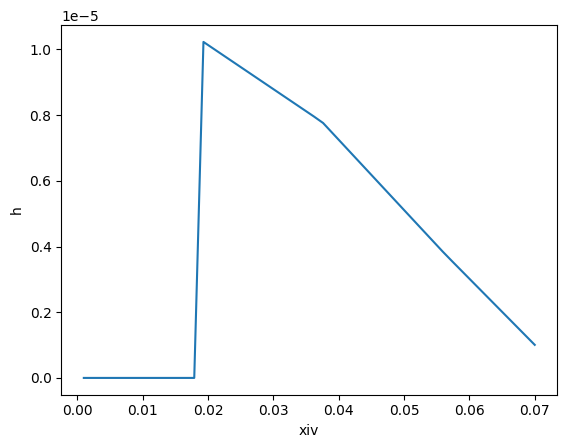

In [89]:
# Test indexing the table with h, c
xivs = np.linspace(0.001,0.07,50)
IhVect = np.vectorize(Ih)
hs = IhVect(0.1, xivs, 0.006,4)
hs[np.isnan(hs)] = 0
plt.plot(xivs, hs)
plt.xlabel("xiv")
plt.ylabel("h");

#Having issues with bounds: maybe some other solver with boundary restrictions?
Lt_hc(3.1479709507529735e-05, 0.1840207972584528, 0.25, 0.046875, Ih, Ic, \
     (min(Lvals), max(Lvals)), (min(tvals), max(tvals)))

# Plotting with Fixed $\xi_m$, $\xi_v$

In [11]:
#----- Plot h(L, t) to see relationship
#Create data
xim = 0.3  #arbitrary
xiv = 0.1 #arbitrary
Ls = np.linspace(min(Lvals)+0.1, max(Lvals)-0.1, 100)
ts = np.linspace(min(tvals)+0.1, max(tvals)-0.1, 100)
hs = np.ones((len(Ls), len(ts)))
cs = np.ones((len(Ls), len(ts)))
for l in range(len(Ls)):
    for t in range(len(ts)):
        hs[l,t] = Ih(xim, xiv, Ls[l], ts[t])
        cs[l,t] = Ic(xim, xiv, Ls[l], ts[t])


x, y = np.meshgrid(Ls, ts)
z1 = hs
z2 = cs

In [13]:
#----- Interactive plots
def interact1(theta, phi):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z1, cmap='inferno')
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    ax.view_init(theta, phi)
    plt.show();

def interact2(theta, phi):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z2, cmap='viridis')
    ax.set_title("Progress Variable (L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("c")
    ax.view_init(theta, phi)
    plt.show();



wgt.interact(interact1, theta=(0,90), phi=(0,360))
wgt.interact(interact2, theta=(0,90), phi=(0,360))

interactive(children=(IntSlider(value=45, description='theta', max=90), IntSlider(value=180, description='phi'…

interactive(children=(IntSlider(value=45, description='theta', max=90), IntSlider(value=180, description='phi'…

<function __main__.interact2(theta, phi)>

# Animate over values of $\xi_{mean}$

In [20]:
#Create data
xim = np.linspace(0.01,0.99,20)
xiv = xim*(1-xim)/2 #Set xiv to be 1/2 of the maximum value for a given xim.
Ls = np.linspace(min(Lvals)+1e-3, max(Lvals)-1e-3, 50)
ts = np.linspace(min(tvals)+1e-3, max(tvals)-1e-3, 50)
hs = np.ones((len(xim), len(Ls), len(ts)))
cs = np.ones((len(xim), len(Ls), len(ts)))
for i in range(len(xim)):
    print(i)
    for l in range(len(Ls)):
        for t in range(len(ts)):
            hs[i,l,t] = Ih(xim[i], xiv[i], Ls[l], ts[t])
            cs[i,l,t] = Ic(xim[i], xiv[i], Ls[l], ts[t])

print("Checkpoint1")
x, y = np.meshgrid(Ls, ts)
z1 = hs
z2 = cs

0
1
2
3
4


/home/jaredwp91/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Checkpoint1


Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  20
Current frame:  21
Current frame:  22
Current frame:  23
Current frame:  24
Current frame:  25
Current frame:  26
Current frame:  27
Current frame:  28
Current frame:  29
Current frame:  30
Current frame:  31
Current frame:  32
Current frame:  33
Current frame:  34
Current frame:  35
Current frame:  36
Current frame:  37
Current frame:  38
Current frame:  39
Current frame:  0


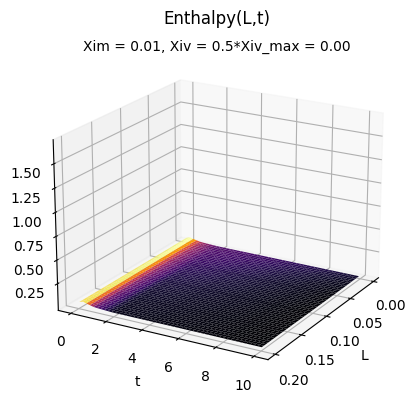

In [27]:
# Animate the plot for enthalpy
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(z1):
        frame = 2*len(z1)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    ax.set_zlim(bottom=np.min(z1), top=np.max(z1))
    surf = ax.plot_surface(x, y, z1[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(z1), interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_VariableXimXiv.gif', writer='pillow', fps=5)

Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  20
Current frame:  21
Current frame:  22
Current frame:  23
Current frame:  24
Current frame:  25
Current frame:  26
Current frame:  27
Current frame:  28
Current frame:  29
Current frame:  30
Current frame:  31
Current frame:  32
Current frame:  33
Current frame:  34
Current frame:  35
Current frame:  36
Current frame:  37
Current frame:  38
Current frame:  39
Current frame:  0


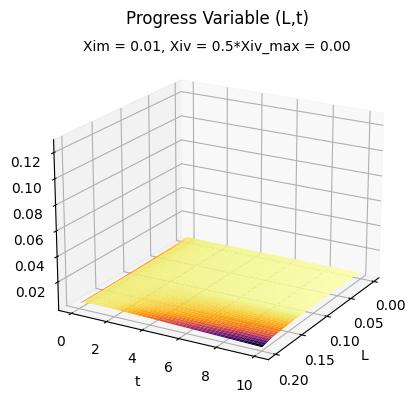

In [28]:
# Animate the plot for progress variable
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(z2):
        frame = 2*len(z2)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Progress Variable (L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("c")
    ax.set_zlim(bottom=np.min(z2), top=np.max(z2))
    surf = ax.plot_surface(x, y, z2[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(z2), interval=200)

# Save the animation as a GIF
ani.save(f'ProgressVariable_VariableXimXiv.gif', writer='pillow', fps=5)

# Archive

### Rotating Plot Animation

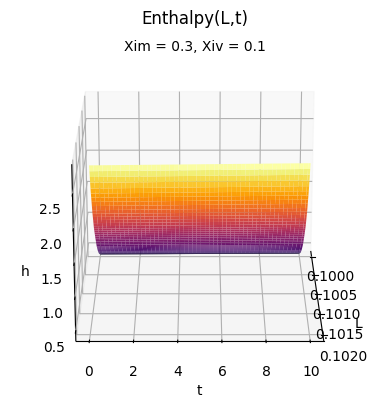

In [12]:
from matplotlib import animation

#----- Animate the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim=4*frame)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    surf = ax.plot_surface(x, y, z1, cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim}, Xiv = {xiv}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=90, interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_xim{xim}_xiv{xiv}.gif', writer='pillow', fps=15)

### Demonstration (using old code)

In [19]:
import LiuInt as LI

#Set constants, get indices
phi = 'T'
ξm = 0.26
ξv = 0.049575
L = 0.002
t = 9
ximi, xivi, Li, ti = valToIndex(ξm, ξv, L, t, indices)

#----- Example with one file and one phi
#Manual Computation
fileName = f'L_{L}U_00{t}.dat'
file1_Tfunc = phiFuncs("/home/jaredwp91/Research/mnt/inferno/codes/flameNew/flame/run", phi, fileName)
phiAvg = LI.IntegrateForPhiBar(ξm, ξv, file1_Tfunc)
print(f"Average {phi} from data in {fileName} (calculated directly) = {phiAvg:.2f} K")
#Tabulated Values
tableVal = table[ximi][xivi][Li][ti]
print(f"Average {phi} from data in {fileName} (tabulated)           = {tableVal:.2f} K\n")


#----- Example with multiple files and one phi
#Manual computation
phiBarVector = np.vectorize(LI.IntegrateForPhiBar)
file1_Tfunc = phiFuncs("/home/jaredwp91/Research/mnt/inferno/codes/flameNew/flame/run", phi)
phiAvg = {key: phiBarVector(ξm, ξv, file1_Tfunc[key]) for key in list(file1_Tfunc)}

#----- Display Setup
print(f"Filename"+" "*(21-len("Filename"))+f"{phi}_avg (calculated)"+" "*8+f"{phi}_avg (tabulated)")
print("----------------------------------------------------------------")

#----- Tabulated Values
vals = []
for i in range(len(indices[2])):
    length = indices[2][i]
    for j in range(len(indices[3])):
        time = indices[3][j]
        ximi, xivi, li, ti = valToIndex(ξm, ξv, length, time, indices)
        SU = ['S', 'U']
        zeros = "0"*(3-len(str(time)))
        key = f'L_{length}{SU[time != 0]}_{zeros}{time}.dat'
        calculated = f"{phiAvg[key]:.2f} K"
        print(f"{key}"+" "*(25-len(key))+calculated+" "*(25-len(calculated))+f"{table[ximi][xivi][li][ti]:.2f} K")

Average T from data in L_0.002U_009.dat (calculated directly) = 407.32 K
Average T from data in L_0.002U_009.dat (tabulated)           = 406.88 K

Filename             T_avg (calculated)        T_avg (tabulated)
----------------------------------------------------------------
L_0.2S_000.dat           1201.25 K                1215.25 K
L_0.2U_001.dat           1144.85 K                1157.46 K
L_0.2U_002.dat           1075.50 K                1086.47 K
L_0.2U_003.dat           990.26 K                 999.30 K
L_0.2U_004.dat           891.83 K                 898.82 K
L_0.2U_005.dat           769.93 K                 774.74 K
L_0.2U_006.dat           654.08 K                 657.56 K
L_0.2U_007.dat           534.42 K                 538.15 K
L_0.2U_008.dat           469.16 K                 472.69 K
L_0.2U_009.dat           398.01 K                 400.26 K
L_0.2U_010.dat           301.58 K                 301.60 K
L_0.04S_000.dat          1238.27 K                1252.25 K
L_0.04U_001

/tmp/ipykernel_255/579430965.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  key = f'L_{length}{SU[time != 0]}_{zeros}{time}.dat'


KeyError: 'L_0.002S_000.dat'

### Benchmarking (unedited)

In [ ]:
from scipy.optimize import curve_fit

# Benchmarking
import time
import matplotlib.pyplot as plt
%matplotlib inline

phi = 'T'
times = np.zeros(8)
for i in range(len(times)):
    start = time.process_time()
    table, indices = lookupTable("/home/jaredwp91/Research/mnt/inferno/codes/flameJWP/run",
                                phi, resolution = i+1)
    t = (time.process_time() - start)
    times[i] = t


res = np.arange(1,9,1)
plt.plot(res, times, '.', label = "Observed Values")
plt.xlabel("Resolution")
plt.ylabel("Processing time (s)")
plt.title("Table Creation Time")

def func(x, a, b):
    return a*x**2 + b*x
p1, p2 = curve_fit(func, res, times)[0]

lin = np.linspace(1,8,100)
plt.plot(lin, func(lin, p1, p2), label = f"t = ({p1:.2f}) r^2 + ({p2:.2f}) r")
plt.legend();

print(f"Valid Xims and Xivs: {indices[1]}")
print()
print(f"Valid Ls and ts: {indices[3]}")

### Other

In [ ]:
def valToIndex(xim, xiv, L, t, indices, thresh = 1e-4):
    """
    DEPRECATED. This functionality is now contained in "createInterpolator"
    Converts values of Xim, Xiv, L, and t to indices for the table resulting from the lookupTable function.
    Inputs:
        xim = value of Xim
        xiv = value of Xiv
        L = value of length scale
        t = value of time step
        indices = second output array of lookupTable
        thresh: Accounts for marginal roundoff error due to linspace
            For example, inputting xiv = 0.0045 in this function will match with tabulated xiv values 0.0045 +- thresh
    Outputs are the indices of the relevant value. For example:
        i_Xim = index of the inputted Xim value in the lookup table
    """
    i_Xim = "err: val not found"
    i_Xiv = "err: val not found"
    i_L = "err: val not found"
    i_t = "err: val not found"

    for x in range(len(indices[0])):
        if (indices[0][x]-xim) <= thresh:
            i_Xim = x
            for y in range(len(indices[1][i_Xim])):
                if (indices[1][x][y]-xiv) <= thresh:
                    i_Xiv = y
    for z in range(len(indices[2])):
        if indices[2][z] == L:
            i_L = z
    for time in range(len(indices[3])):
        if indices[3][time] == t:
            i_t = time
    return i_Xim, i_Xiv, i_L, i_t

In [ ]:
#Testing Grounds

#Array masking
a = np.ones(10)*(-1)
for i in range(len(a)-1):
    a[i] = np.random.rand()
aNew = a[a!=-1]

#Regex
pattern = r"L_([\d.]+)[SU]_([\d.]+)\.dat"
candidates = ["L_0.03U_198.dat", "L_0.002S_299.dat", "L0990U900.dat"]
for c in candidates:
    print(search(pattern, c))

L = 0.03
pattern2 =  f"L_{L}[SU]_[\d]*\.dat"
arr2 = ["L_0.02S_001.dat", "L_0.02S_003.dat", "L_0.02S_002.dat", "L_0.02U_001.dat", "L_0.03S_001.dat"]
print("Here", len([name for name in arr2 if match(pattern2, name)]))
arr = [0.1, 0.4, 0.5, 0.2, 0.7, 0.15]
print(np.sort(arr)[::-1])

In [ ]:
# Fidelity Test: trying to determine the behavior of the BetaPDF near 0 and 1
import LiuInt as LI
function = phiFuncs("../flame/run", 'T', fileName = 'L_0.002U_24.dat')

#For what value of xim is xim = 0 = x a good approximation? 
#Hypothesis: Something beneath 1e-6 will work fine. 
Min = -1
xim = np.logspace(0, Min,10)
xiv = np.logspace(0, Min,10)
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
  
# Creating 2-D grid of features 
[X, Y] = np.meshgrid(xim, xiv) 
  
fig, ax = plt.subplots(1, 1) 

Z = np.zeros((len(xim), len(xiv)))
for i in range(len(xim)):
    for j in range(len(xiv)):
        Z[i,j] = LI.IntegrateForPhiBar(xim[i], xiv[j], function)

# plots filled contour plot 
ax.contourf(X, Y, Z) 
  
ax.set_title('Predicted values') 
ax.set_xlabel('Xim') 
ax.set_xscale('log')
ax.set_ylabel('Xiv')
ax.set_yscale('log')
cs = ax.contourf(X, Y, Z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
  
plt.show() 
plt.savefig('Fidelity_min.png', dpi=300, bbox_inches='tight')

In [14]:
# First attempt to show interaction of h(L,t) and c(L,t). 
# Plot isn't useful because of scaling differences: No aparent 
#        meaning to the intersections
def interact(theta, phi, l, t):
    def h(xim, xiv):
        ijko = valToIndex(xim, xiv, l, t, h_indices)
        i = ijko[0]
        j = ijko[1]
        k = ijko[2]
        o = ijko[3]
        return h_table[i][j][k][o]
    hvect = np.vectorize(h)

    def c(xim, xiv):
        ijko = valToIndex(xim, xiv, l, t, c_indices)
        i = ijko[0]
        j = ijko[1]
        k = ijko[2]
        o = ijko[3]
        return c_table[i][j][k][o]
    cvect = np.vectorize(c)

    hxims = h_indices[0]
    hxivs = h_indices[1]
    cxims = c_indices[0]
    cxivs = c_indices[1]

    HXM, HXV = np.meshgrid(hxims, hxivs)
    H = hvect(HXM, HXV)
    CXM, CXV = np.meshgrid(cxims, cxivs)
    C = cvect(CXM, CXV)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(CXM, CXV, C, rstride=1,cstride=1,
                    cmap='plasma', edgecolor='none')
    ax.plot_surface(HXM, HXV, H, rstride=1,cstride=1,
                    cmap = 'viridis', edgecolor='none')
    ax.set_xlabel('Xim')
    ax.set_ylabel('Xiv')
    ax.set_zlabel("h or c")
    ax.set_title("h(Xim, Xiv) and c(Xim, Xiv)")
    ax.view_init(theta, phi)
    plt.show()

wgt.interact(interact, theta=(0,90), phi=(0,360), l = (0.02,0.02), t = (6,6))

print("Hot colors are c, Cooler colors are h")

interactive(children=(IntSlider(value=45, description='theta', max=90), IntSlider(value=180, description='phi'…

Hot colors are c, Cooler colors are h


In [57]:
# Plot an interactive version of  phi(L,t)
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as wgt

def interact(theta, phi):
    #Temperature in terms of l and t
    def f(l, t):
        ij = valToIndex(-1,-1,l,t, indices)
        i = ij[2]
        j = ij[3]
        return table[2][2][i][j] #Arbitrarily use the third value of xim and xiv
    fvect = np.vectorize(f)
    
    x = indices[2] #Ls
    y = indices[3] #ts
    
    X, Y = np.meshgrid(x, y)
    Z = fvect(X, Y)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_xlabel('L')
    ax.set_ylabel('t')
    ax.set_zlabel('Temperature')
    ax.set_title('Temp(L,t)')
    ax.view_init(theta, phi)
    plt.show()

wgt.interact(interact, theta=(0,90), phi=(0,360));

interactive(children=(IntSlider(value=45, description='theta', max=90), IntSlider(value=180, description='phi'…